### Evaluate the conversation flows of twitter respond-trees

This notebook is a documentation on how particulary damaging tweets might be filtered
out by looking at them from a sentiment delta perspective.

First we download the data from our database.

In [64]:
import sqlite3
import pandas as pd

# Create your connection.
cnx = sqlite3.connect('db.sqlite3')

df = pd.read_sql_query(
    "SELECT id, conversation_id, sentiment,sentiment_value,created_at, tn_level, tn_order FROM delab_tweet where sentiment = 'positive' or sentiment = 'negative'", cnx)

df.head(3)

,id,conversation_id,sentiment,sentiment_value,created_at,tn_level,tn_order
0,1,1426273610289848324,positive,8.078357,2021-08-13 20:05:02,1,0
1,2,1426273610289848324,negative,-0.479819,2021-08-16 14:43:39,2,1
2,3,1426273610289848324,positive,0.496286,2021-08-16 14:37:31,2,2


The conversation_id corresponds to the twitter field with the same name.  The sentiment values
are computed using a neural net and trax, using twitter samples as training data.

Depending on the state of the database different length of conversations are downloaded present:

In [65]:
df['conversation_id'].value_counts()



1427288915241693191    27
1426985024021278729    25
1427278723636776961    13
1427264644813627394    11
1426273610289848324    10
Name: conversation_id, dtype: int64

Next we group the data by the conversation_id.



In [66]:
example_id = df.at[0, 'conversation_id']  # select the first conversation as an example
# df_subset = df[~df.sentiment_value.isnull()]
df_subset = df[df.conversation_id == example_id]
df_subset= df_subset.sort_values(by=['created_at'])
df_subset.reset_index(drop=True, inplace=True)
df_subset.head(5)

,id,conversation_id,sentiment,sentiment_value,created_at,tn_level,tn_order
0,1,1426273610289848324,positive,8.078357,2021-08-13 20:05:02,1,0
1,11,1426273610289848324,negative,-7.684655,2021-08-13 20:12:48,2,10
2,7,1426273610289848324,positive,7.635874,2021-08-13 21:04:45,2,6
3,9,1426273610289848324,positive,7.135094,2021-08-13 21:11:12,3,8
4,6,1426273610289848324,negative,-2.882568,2021-08-14 00:30:18,2,5


Now we are using rolling mean to get a better idea of significant changes.
The rolling mean looks at a windows n (here 3) tweets and smoothens the curve accordingly:
https://en.wikipedia.org/wiki/Moving_average

In [67]:
rolling_column = df_subset['sentiment_value'].rolling(3).mean()
df_subset = df_subset.assign(rolling_sentiment=rolling_column)
df_subset.head(5)

,id,conversation_id,sentiment,sentiment_value,created_at,tn_level,tn_order,rolling_sentiment
0,1,1426273610289848324,positive,8.078357,2021-08-13 20:05:02,1,0,NaN
1,11,1426273610289848324,negative,-7.684655,2021-08-13 20:12:48,2,10,NaN
2,7,1426273610289848324,positive,7.635874,2021-08-13 21:04:45,2,6,2.676525
3,9,1426273610289848324,positive,7.135094,2021-08-13 21:11:12,3,8,2.362104
4,6,1426273610289848324,negative,-2.882568,2021-08-14 00:30:18,2,5,3.962800


### Plotting the rolling average to highlight extreme posts

We use the index as x_axis and the rolling average of the sentiment value as y.
This is the graph that is displayed in the proof-of-concept website.

<AxesSubplot:>

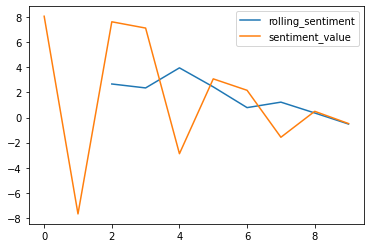

In [68]:
df_subset.plot(y=['rolling_sentiment', 'sentiment_value'], use_index=True)

In order to find out candidates with the highest impact we can look at the differentials.

$$ candidate_{conv} = \arg\max_{x\in n}(x_{n+1}-x_n) \land |conv| = n  $$

We can already see the issue that very early tweets or the last ones are not defined by this.

In [69]:
diffs = df_subset.rolling_sentiment.diff().abs()
#df_subset["diffs"]=diffs
df_subset = df_subset.assign(rolling_deltas=diffs)
df_subset.head(10)

,id,conversation_id,sentiment,sentiment_value,created_at,tn_level,tn_order,rolling_sentiment,rolling_deltas
0,1,1426273610289848324,positive,8.078357,2021-08-13 20:05:02,1,0,NaN,NaN
1,11,1426273610289848324,negative,-7.684655,2021-08-13 20:12:48,2,10,NaN,NaN
2,7,1426273610289848324,positive,7.635874,2021-08-13 21:04:45,2,6,2.676525,NaN
3,9,1426273610289848324,positive,7.135094,2021-08-13 21:11:12,3,8,2.362104,0.314421
4,6,1426273610289848324,negative,-2.882568,2021-08-14 00:30:18,2,5,3.962800,1.600695
5,8,1426273610289848324,positive,3.084620,2021-08-14 05:56:13,3,7,2.445715,1.517085
6,5,1426273610289848324,positive,2.172888,2021-08-15 04:45:31,2,4,0.791647,1.654069
7,4,1426273610289848324,negative,-1.571838,2021-08-15 07:18:11,2,3,1.228557,0.436910
8,3,1426273610289848324,positive,0.496286,2021-08-16 14:37:31,2,2,0.365779,0.862778
9,2,1426273610289848324,negative,-0.479819,2021-08-16 14:43:39,2,1,-0.518457,0.884236


Next we are printing the candidate tweet that changed the dicussion the most based on the sentiment predictions:

In [70]:
pd.options.display.max_colwidth=500 # so we can see the full tweet
ix_of_candidate = df_subset.rolling_deltas.argmax()-1
id_of_candidate = df_subset.loc[ix_of_candidate,"id"]

df_candidate = pd.read_sql_query(
    "SELECT id, text FROM delab_tweet where id='{}'".format(id_of_candidate), cnx)

df_candidate = df_candidate.assign(sentiment_delta=df_subset.iloc[ix_of_candidate+1].rolling_deltas)
#print(df_candidate.text)
df_candidate.head()


,id,text,sentiment_delta
0,8,"@banon_enrique @RedCrossCasc @OregonGovBrown @211info I wonder if I think about air conditioning enough if I can materialize one in my house. The act of knowing about air conditioning is going to summon air conditioners to everyone. Gosh, I shoulda known about this power, such a simple thing.",1.654069


### Questions that arise from the data:
- Does the tree level (is a tweet answer of an answer of an answer lvl3 ...) matter?
- The rolling average leaves NaN for the first n tweets, is that a problem?
- How long does the conversation have to be in order for the delta to be significant?
- Is the underlying sentiment analysis predictive enough (and accurate enough)?
- The rolling average might be biased by the last tweet (as it makes up 100% of the average in the end)
- The rolling average might be substituted for a method more suited for lower number of data points